<a href="https://www.kaggle.com/alexteboul/tutorial-part-3-cnn-image-modeling-1?scriptVersionId=89713796" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Tutorial Part 3: CNN Image Modeling 1
Hello and welcome to Part 3 of this Pawpularity Contest Tutorial Series. 

**In this 'Tutorial Part 3: CNN Image Modeling 1', you'll learn:**
* How to read in and pre-process the images for modeling
* How to perform data augmentation in 1 line of code
* How to build a basic Convolutional Neural Network (CNN)
* How to predict RMSE using your CNN architecture
* How to evaluate your models
* How to submit your predictions for the competition

**Other Tutorials in this series:**
* In [Tutorial Part 1: EDA for Beginners](https://www.kaggle.com/alexteboul/tutorial-part-1-eda-for-beginners), we covered the exploratory data analysis process from start to finish for the PetFinder.my Pawpularity Contest. 
* In [Tutorial Part 2: Model Building using the Metadata](https://www.kaggle.com/alexteboul/tutorial-part-2-model-building-using-the-metadata), we built models using the metadata (.csv data) provided by the competition hosts. Specifically, we tried Decision Tree Classification, Decision Tree Regression, Ordinary Least Squares Regression, Ridge Regression, Bernoulli Naive Bayes Classification, Random Forest Regression, and Histogram-based Gradient Boosting Regression (LightGBM).

TLDR on the first 2 Tutorials, all the metadata models suck because the metadata isn't strongly predictive of / correlated with the target class "Pawpularity". You could just guess the mean Pawpularity value for every image and get a similar RMSE score - which is what many of the models learned to do. Sometimes it's just not possible to build highly predictive models. Not because of the data you have collected, but because the target class may simply be a random distribution. Pawpularity may just not have much to do with the images themselves. That said, today we are going to see if we can lower our RMSE score by building models using the images. Specifically, we're going to explore basic Convolutional Neural Networks (CNNs) and Transformers.

**Score to beat: 20.52**

**Index:**
1. Load in the packages
2. Get the data
3. Model Building

## 1. Load in the packages

In [1]:
#packages
#basics
import os
import numpy as np
import pandas as pd

#images
import cv2

#modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Check to see
tf.config.get_visible_devices()

2022-03-10 02:28:32.123230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:32.224728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:32.225866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#check if GPU available to use - works well in google colab but kaggle varies. Can use just CPU, GPU, or TPU or mix. 
if 'GPU' in str(device_lib.list_local_devices()):
    config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0})
    sess = tf.compat.v1.Session(config=config) 

2022-03-10 02:28:32.332506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 02:28:32.333785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:32.335000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:32.335930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## 2. Get the data
The trickiest part of modeling using images in my opinion is often getting them in the right format to be used by your ML model architectures. You need to know where your images are, and then turn them into the data types that can be accepted by your models. If your images are already in directories with their associated classes, there are some straighforward ways to read in the data. Imagine the file paths: /train/26/1239581345.jpg and /train/93/1239581345.jpg where the classes would be a pawpularity score of 26 in the first case and 93 in the second case. That is NOT the case for this competition.

For our purposes, an easy way to get our data is to:
1. Get the image paths from train.csv and test.csv files. The image files are named the same as the Ids in the Id column of the csv's.
2. Then, create a function that will preprocess all the images and put then into an array/tensor. At a basic level, you want to turn the all training images into one super big array. That is what will be fed into your ML model. So you don't feed the images in based on their image paths/URLs, you have to turn them all into a single array/tensor before the model can be fit to the images.
3. Preprocess the images using your function. Display the result.

In [4]:
#get the data
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

In [5]:
#Modify the Id such that each Id is the full image path. In the form
def train_id_to_path(x):
    return '../input/petfinder-pawpularity-score/train/' + x + ".jpg"
def test_id_to_path(x):
    return '../input/petfinder-pawpularity-score/test/' + x + ".jpg"

#Read in the data and drop unnecessary columns
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

#Add the .jpg extensions to the image file name ids
train["img_path"] = train["Id"].apply(train_id_to_path)
test["img_path"] = test["Id"].apply(test_id_to_path)

It may also be helpful for us to build models where we try to turn this into a classification problem. So instead of the model predicting Pawpularity scores between 1-100, it could predict low v. high, or some other arrangement of bins. To do this, you can use pd.qcut(). The q value you specify determins the number of bins/classes the target column will get split up into fairly equally. You can specify labels in a list as well.

For the sake of clarity, I moved this to Tutorial Part 4: CNN Image Modeling 2

In [6]:
#binning columns to test models
train['two_bin_pawp'] = pd.qcut(train['Pawpularity'], q=2, labels=False)
train = train.astype({"two_bin_pawp": str})

train['four_bin_pawp'] = pd.qcut(train['Pawpularity'], q=4, labels=False)
train = train.astype({"four_bin_pawp": str})

train['ten_bin_pawp'] = pd.qcut(train['Pawpularity'], q=10, labels=False)
train = train.astype({"ten_bin_pawp": str})

Here we can see exactly how the data is split up. If we model on this, we'll still need to at some point turn the predictions back into scores between 1-100 for evaluation though.

In [7]:
train2bin_stats = train.groupby('two_bin_pawp')
train2bin_stats.describe()

Pawpularity                                                     
                   count       mean        std   min   25%   50%   75%    max
two_bin_pawp                                                                 
0                 5038.0  23.351727   7.628728   1.0  20.0  25.0  29.0   33.0
1                 4874.0  53.220558  18.673900  34.0  39.0  47.0  62.0  100.0

In [8]:
train4bin_stats = train.groupby('four_bin_pawp')
train4bin_stats.describe()

Pawpularity                                                     
                    count       mean        std   min   25%   50%   75%    max
four_bin_pawp                                                                 
0                  2638.0  17.871494   6.597751   1.0  14.0  20.0  23.0   25.0
1                  2400.0  29.375417   2.240328  26.0  27.0  29.0  31.0   33.0
2                  2401.0  39.198667   3.661639  34.0  36.0  39.0  42.0   46.0
3                  2473.0  66.834209  17.263356  47.0  52.0  62.0  78.0  100.0

In [9]:
train10bin_stats = train.groupby('ten_bin_pawp')
train10bin_stats.describe()

Pawpularity                                                      
                   count       mean        std   min   25%   50%    75%    max
ten_bin_pawp                                                                  
0                 1100.0  11.512727   5.459323   1.0   7.0  13.0   16.0   18.0
1                  998.0  21.278557   1.385033  19.0  20.0  21.0   22.0   23.0
2                 1158.0  25.574266   1.098877  24.0  25.0  26.0   27.0   27.0
3                  940.0  29.000000   0.822992  28.0  28.0  29.0   30.0   30.0
4                  842.0  31.913302   0.804765  31.0  31.0  32.0   33.0   33.0
5                  948.0  35.455696   1.115854  34.0  34.0  35.0   36.0   37.0
6                 1074.0  40.455307   1.677757  38.0  39.0  40.0   42.0   43.0
7                  921.0  47.247557   2.215940  44.0  45.0  47.0   49.0   51.0
8                  953.0  58.261280   4.306525  52.0  55.0  58.0   62.0   66.0
9                  978.0  85.171779  12.107888  67.0  74.0  84.0  100.0  100.0

In [10]:
#show the full training dataframe now
train.head()

,Id,Pawpularity,img_path,two_bin_pawp,four_bin_pawp,ten_bin_pawp
0,0007de18844b0dbbb5e1f607da0606e0,63,../input/petfinder-pawpularity-score/train/000...,1,3,8
1,0009c66b9439883ba2750fb825e1d7db,42,../input/petfinder-pawpularity-score/train/000...,1,2,6
2,0013fd999caf9a3efe1352ca1b0d937e,28,../input/petfinder-pawpularity-score/train/001...,0,1,3
3,0018df346ac9c1d8413cfcc888ca8246,15,../input/petfinder-pawpularity-score/train/001...,0,0,0
4,001dc955e10590d3ca4673f034feeef2,72,../input/petfinder-pawpularity-score/train/001...,1,3,9


In [11]:
#show the full testing dataframe now. Notice how we don't have anything besides the image file paths/ids. 
#These are what we will use to make our submissions. 
test.head()

,Id,img_path
0,4128bae22183829d2b5fea10effdb0c3,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,../input/petfinder-pawpularity-score/test/8f49...


For the pre-processing function that will get our images, these are some useful documentation links. For our first run through, we'll use the full rgb images. So 3 channels. If you wanted you could change the images to grayscale in this function. We read in the file, then decode the image, normalize, and resize.
Function path_to_eagertensor() documentation
* https://www.tensorflow.org/api_docs/python/tf/io/read_file
* https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg
* https://www.tensorflow.org/api_docs/python/tf/cast
* https://www.tensorflow.org/api_docs/python/tf/image/resize
* https://www.tensorflow.org/api_docs/python/tf/image/resize_with_pad

In [12]:
#Set the size image you want to use
image_height = 128
image_width = 128

#define a function that accepts an image url and outputs an eager tensor
def path_to_eagertensor(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.resize_with_pad(image, image_height, image_width) #optional with padding to retain original dimensions
    image = tf.image.resize(image, (image_height, image_width))
    return image

In [13]:
#show the image file path for the first image in the training data
print(train['img_path'][0])

../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg


(720, 405, 3)


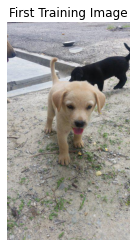

In [14]:
#let's plot that first image:
#use plt.imread() to read in that image file
og_example_image = plt.imread('../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg') 
print(og_example_image.shape)

#then plt.imshow() can display it for you
plt.imshow(og_example_image)
plt.title('First Training Image') 
plt.axis('off') #turns off the gridlines
plt.show()

In [15]:
%%capture
#run the function to show the pre-processing on the first training image only
example_image = path_to_eagertensor('../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg')

2022-03-10 02:28:36.828338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:36.829710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:36.831170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:36.833080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 02:28:36.834727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Make note below of the data type that the example_image was turned into after applying our pre-processing funciton. Also note that the shape of the image has been resized.

type:  <class 'tensorflow.python.framework.ops.EagerTensor'> 
 shape:  (128, 128, 3)


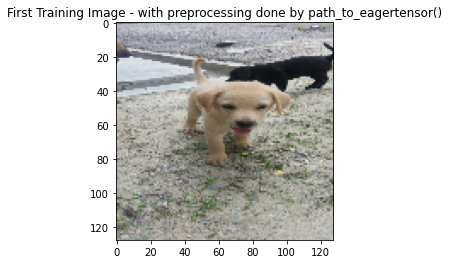

In [16]:
#show the type 
print('type: ', type(example_image),'\n shape: ',example_image.shape)
plt.imshow(example_image)
plt.title('First Training Image - with preprocessing done by path_to_eagertensor()') 
plt.show()

Now, with a simple for loop, you can run the preprocessing function on all the image paths in the training dataframe and next the testing dataframe. By training and testing I mean the data from the training.csv and testing.csv.

In [17]:
#get all the images in the training folder and put their tensors in a list
X = []
for img in train['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X.append(new_img_tensor)
    
print(type(X),len(X))
X = np.array(X)
print(type(X),X.shape)

<class 'list'> 9912
<class 'numpy.ndarray'> (9912, 128, 128, 3)


In [18]:
#get all the images in the test folder and put their tensors in a list
X_submission = []
for img in test['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X_submission.append(new_img_tensor)
    
print(type(X_submission),len(X_submission))
X_submission = np.array(X_submission)
print(type(X_submission),X_submission.shape)


<class 'list'> 8
<class 'numpy.ndarray'> (8, 128, 128, 3)


**We've now finished the steps to get our data. As a result, we have:**
* 2 numpy arrays
 * Array 1 is our training data array composed of all our training preprocessed images (from ../train/*.jpg): X
 * Array 2 is our testing data array composed of the test preprocessed images (from ../test/*.jpg): X_submission
* We will use X for our model building / training / evaluation of our models
* We will use X_submission for our submission predictions

## 3. Model Building
Now that we have our data, building the models themselves is a pretty straightforward process. 

At a basic level, you can think of model building with images as having 5 steps:
1. Split up your data into training and testing (split up the X numpy array)
2. Define a model architecture
3. Compile your model 
4. Fit your model to the training data you have split off in your train_test_split. 
5. Use your now trained model to predict on new data (X_submission)

### 3.1 Split up you data into training and testing

In [19]:
#grab the target variable. In our case, Pawpularity
y = train['Pawpularity']
print(type(y))

<class 'pandas.core.series.Series'>


In [20]:
#generate train - test splits  90% train - 10% test
#You usually don't want to do a 90-10 split unless you have a lot of data, 
#but we get to evaluate performance using the leaderboard submissions as well
#So I really want this model to see as many pets as possible in trianing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [21]:
#Show the shape of each of the new arrays
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8920, 128, 128, 3) (992, 128, 128, 3) (8920,) (992,)


### 3.2 Define your model architecture
This is the secret sauce of many ML models. It can get quite complicated when you have different layers of your network interacting with eachother. For our example, we'll stick to a basic architecture and explain each step. Basically:
* [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) - defines a convolutional layer and you can mess with parameters
* [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) - Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
* [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
* [tf.keras.layers.MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) - a way to perform dimensionality reduction by taking the max value in the pool along strides.
* **strides** - The strides parameter is a 2-tuple of integers, specifying the “step” of the convolution along the x and y axis of the input volume. This can sometimes be used instead of doing max pooling. Reduces volume.
* **kernel_size** - The size of the kernel. A kernel is a filter that is used to extract the features from the images. The kernel is a matrix that moves over the input data, performs the dot product with the sub-region of input data, and gets the output as the matrix of dot products
* **padding** - Can be "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
* *kernel_regularizer=l2(0.0002)* - performing regularization can help prevent overfitting. That's when your model is to attuned to the training data and doesn't generalize well. So you might be really good on your training metrics, but then your predictions could be totally off. The smaller the value applied here, the less impact it'll have. 

You may also see this look different, where some people like to use .add() to add layers to their model architecture. So you might see something like:

* model_a = tf.keras.models.Sequential()
* model_a.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3), data_format="channels_last"))
* model_a.add(BatchNormalization())
* model_a.add(MaxPooling2D(pool_size=(2, 2)))
* model_a.add(Dropout(0.5))
* model_a.add(Conv2D(32, (3, 3), activation='relu'))
* model_a.add(Flatten())
* model_a.add(Dense(32, activation='relu'))
* model_a.add(BatchNormalization())
* model_a.add(Dropout(0.5))
* model_a.add(Dense(1, activation='linear')) 

This is acceptable too in most cases. My personal preference is to use this format you'll see coded below. 


In [22]:
#define the inputs to your model. Basically the shape of the incoming data
inputs = tf.keras.Input(shape=(image_height,image_width,3))

#start off with x just being those inputs
x = inputs

x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (7,7), strides = (2,2), padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)


x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs = inputs, outputs = output)

**Use model.summary() to actually show the model architecture**

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 16)        2368      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0     

Usually you want to use CNNs for classification tasks. And the Pawpularity score is a poor metric to classify given the minimal visual difference between the images at varying Pawpularity scores. A pet scored at 26 pawpularity is not so different from a pet scored at a 27 - it's not like a dog and a car. But we'll do the basics here to show this as a regression type task.

### 3.3 Compile your model

In [24]:
#compile the model
model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae", "mape"])

### 3.4 Fit your model using the training data

Just fit the model to the training data. A helpful addition here is usually to do some data augmentation.
* [tf.keras.preprocessing.image.ImageGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) - This generates batches of tensor image data for real-time data augmentation.
 * Just call your generator.flow() when you .fit() your model to use this real time data augmentation.
* [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) - groups layers into an object with training and inference features.

In [25]:
#you can use this to provide your model with different variations of the same images. 
# It doesn't actually make and save a bunch of new images, just defines how new images can be created. 
# These transformations will randomly be applied to the training images as they get used in training.
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")

When we fit our model here, note that we're using the real-time data augmentation. Also note that we validation_data is the x_test and y_test from our train_test_split before.

In [26]:
history = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=32),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 32,
    epochs = 60
)

2022-03-10 02:30:44.179700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-03-10 02:30:46.577025: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


278/278 [==============================] - 43s 127ms/step - loss: 492.1245 - rmse: 22.1783 - mae: 16.6018 - mape: 79.9944 - val_loss: 448.3558 - val_rmse: 21.1684 - val_mae: 15.8957 - val_mape: 77.6614
Epoch 2/60
278/278 [==============================] - 35s 125ms/step - loss: 469.4402 - rmse: 21.6606 - mae: 16.1784 - mape: 80.0572 - val_loss: 562.4499 - val_rmse: 23.7105 - val_mae: 16.6228 - val_mape: 65.8155
Epoch 3/60
278/278 [==============================] - 35s 127ms/step - loss: 466.2177 - rmse: 21.5860 - mae: 16.1177 - mape: 78.9759 - val_loss: 461.4868 - val_rmse: 21.4760 - val_mae: 15.8951 - val_mape: 75.9005
Epoch 4/60
278/278 [==============================] - 35s 124ms/step - loss: 462.8424 - rmse: 21.5075 - mae: 16.0851 - mape: 79.2437 - val_loss: 434.2041 - val_rmse: 20.8310 - val_mae: 15.7780 - val_mape: 78.7257
Epoch 5/60
278/278 [==============================] - 35s 125ms/step - loss: 461.0534 - rmse: 21.4658 - mae: 16.0053 - mape: 78.8356 - val_loss: 451.5800 - val

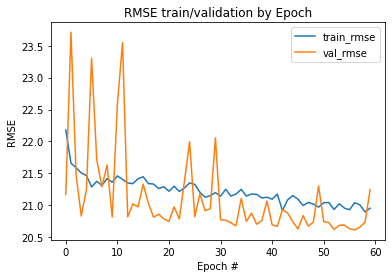

In [27]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
#plt.xticks(range(0,60))
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

### 3.5 Now use your newly trained model on unseen data + make your submission!

In [28]:
#predict on the submission data
cnn_pred = model.predict(X_submission)
print(X_submission.shape, type(X_submission))
print(cnn_pred.shape, type(cnn_pred))

(8, 128, 128, 3) <class 'numpy.ndarray'>
(8, 1) <class 'numpy.ndarray'>


In [29]:
#put the submission predictions alongside their associated Ids
cnn = pd.DataFrame()
cnn['Id'] = test['Id']
cnn['Pawpularity'] = cnn_pred
cnn.to_csv('submission.csv',index=False)

In [30]:
cnn.head(10)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,37.929852
1,43a2262d7738e3d420d453815151079e,38.463207
2,4e429cead1848a298432a0acad014c9d,38.192894
3,80bc3ccafcc51b66303c2c263aa38486,38.382298
4,8f49844c382931444e68dffbe20228f4,38.183250
5,b03f7041962238a7c9d6537e22f9b017,37.739784
6,c978013571258ed6d4637f6e8cc9d6a3,38.713104
7,e0de453c1bffc20c22b072b34b54e50f,39.053200


(128, 128, 3)


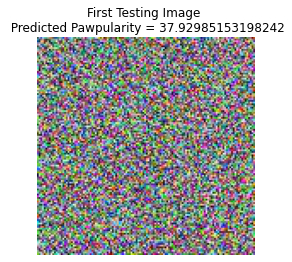

In [31]:
testing_example_image = plt.imread('../input/petfinder-pawpularity-score/test/4128bae22183829d2b5fea10effdb0c3.jpg') 
print(testing_example_image.shape)
#then plt.imshow() can display it for you
plt.imshow(testing_example_image)
plt.title('First Testing Image \n Predicted Pawpularity = {}'.format(cnn['Pawpularity'].iloc[0])) 
plt.axis('off') #turns off the gridlines
plt.show()

All that for our model to just predict the Pawpularity scores near the median Pawpularity score every single time! 🤦🏻‍♂️ Well it was seeing random noise, so this is actually a good thing! Yeah that's right, the sample images in the ../test/ subdirectory are all like that. So if you're getting super specific predictions for random noise, something is probably off here lol. That said, the model did just learn to basically guess the median for everything.

Still, better to switch to classification and use the bins we created earlier. Feel free to modify the model architecture, data augmentation, preprocessing, image size, etc to see if you can improve the score. To keep things clean, I'll share the classification and binning methods in a new notebook Tutorial Part 3: CNN Image Modeling 2

#### For Fun - see prediction on an image of your choice - here training image #1

In [32]:
#Empty List
Sample_image_prediction = []
#Preprocess with our function
sample_new_img_tensor = path_to_eagertensor('../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg')
Sample_image_prediction.append(sample_new_img_tensor)
Sample_image_prediction = np.array(Sample_image_prediction)
#Show data type is good to input into model
print(type(Sample_image_prediction),Sample_image_prediction.shape)

<class 'numpy.ndarray'> (1, 128, 128, 3)


In [33]:
sample_cnn_pred = model.predict(Sample_image_prediction)
print(sample_cnn_pred,sample_cnn_pred.shape, type(sample_cnn_pred))

[[34.35458]] (1, 1) <class 'numpy.ndarray'>


(720, 405, 3)


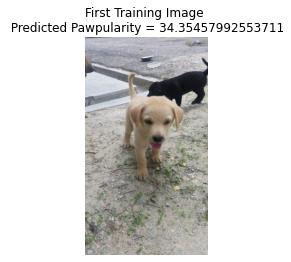

In [34]:
sample_example_image = plt.imread('../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg') 
print(sample_example_image.shape)
#then plt.imshow() can display it for you
plt.imshow(sample_example_image)
plt.title('First Training Image \n Predicted Pawpularity = {}'.format(sample_cnn_pred[0][0])) 
plt.axis('off') #turns off the gridlines
plt.show()